# Machine learning methods for predicting microbial community dynamics using microbial abundance as predictor

1) for test   
2) input data: asv abundance of previous points, output: asv abundance   
3) model used: dummy, linear regression, Ridge regresion, PCR, PLS, random forest, a self-defined linear regression.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import pandas as pd
import numpy as np

## Models 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel


import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


## self models
from scipy.optimize import minimize
from joblib import Parallel
from sklearn.utils.fixes import delayed


In [2]:
## read files
os.chdir("C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\Air01")  # set dir location
# env=pd.read_csv('Air01A1.Env.fillna.csv')
asv=pd.read_csv('Air01A1.ASV.Top100.csv') ## or read top 100 asv files
# envnp=env[env.columns[1:]].to_numpy(dtype='float32')
asvnp=asv[asv.columns[1:]].to_numpy(dtype='float32').T
outpath='top5_predicted/'

In [9]:
env.shape

NameError: name 'env' is not defined

## Define functions

In [3]:
## Define user functions
def split_samples(data,train_size,test_size):
    """ split samples for test (later) and train (former) samples"""
    train=data[(len(data)-test_size-train_size):(len(data)-test_size),:]
    test=data[(len(data)-test_size):,:]
    return train,test
    

def geo_mean_overflow(iterable):
    """calculated geometric mean"""
    
    return np.exp(np.log(iterable).mean(axis=1))


## Could be a problem adding 0.01 when the data strucutre is very sparse
def relative_abundance(comm,add=0):
    """ calculate relative abudance andd add a value for 0 value"""
    comm=comm/comm.sum(axis=1)[:,None]
    comm[comm==0]=add
    comm=comm/comm.sum(axis=1)[:,None]
    return(comm)

def Centerlogtransform(comm,add=0.01):
    """ centered log ratio for community data"""
    comm=relative_abundance(comm,add=add)
    comm=np.log(comm/geo_mean_overflow(comm)[:,None])
    return comm

def Centerlogtransform_back(comm):
    """ transform back for centered log ratio"""
    comm=np.exp(comm)/np.exp(comm).sum(axis=1)[:,None]
    return comm

def acc(ytrue,ypred):
    """ return accuracy = Ca, precision = r, ccc = rc""" 
    if ytrue.ndim<2:
        y=ypred
        x=ytrue
        d = y - x
        m1 = np.mean(y)
        m2 = np.mean(x)
        v1 = np.var(y)
        v2 = np.var(x)
        n = len(d)
        e2 = np.sum(d*d)/n
        mu_d = m1 - m2
        d2 = mu_d**2
        s12 = v1 
        s22 = v2 ## var is different for R and python
        U = mu_d/np.sqrt(np.sqrt(s12 * s22))
        V = np.sqrt(s12/s22)
        Ca = 2/(V + 1/V + U**2)
        rc = 1 - e2/(d2 + s12 + s22)
        r = (rc/Ca)
        return Ca, r, rc
    else:
        Ca_sum=0
        r_sum=0
        rc_sum=0
        for i in range(ytrue.shape[1]):
                    y=ypred[:,i]
                    x=ytrue[:,i]
                    d = y - x
                    m1 = np.mean(y)
                    m2 = np.mean(x)
                    v1 = np.var(y)
                    v2 = np.var(x)
                    n = len(d)
                    e2 = np.sum(d*d)/n
                    mu_d = m1 - m2
                    d2 = mu_d**2
                    s12 = v1 
                    s22 = v2 ## var is different for R and python
                    U = mu_d/np.sqrt(np.sqrt(s12 * s22))
                    V = np.sqrt(s12/s22)
                    Ca_sum+= 2/(V + 1/V + U**2)
                    rc_sum+= 1 - e2/(d2 + s12 + s22)
                    r_sum== ((1 - e2/(d2 + s12 + s22))/(2/(V + 1/V + U**2)))
        return Ca_sum/ytrue.shape[1], r_sum/ytrue.shape[1], rc_sum/ytrue.shape[1]
    
    
def ts_train_test_normalize(all_data,test_end,train_size,test_size,time_steps,for_periods,asvID,add=0,clr="FALSE"):
    '''
    input: 
      data: dataframe with dates and ASV data
    output:
      X_train, y_train: data from the first 45 weeks
      X_test:  data of the final 6 weeks -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[(test_end-test_size-train_size):(test_end-test_size),asvID]
    ts_test  = all_data[(test_end-test_size):test_end,asvID]
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    #from sklearn.preprocessing import MinMaxScaler
    #sc = MinMaxScaler(feature_range=(0,1))
    #ts_train_scaled = sc.fit_transform(ts_train.reshape(-1,1))

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-for_periods+1): 
        X_train.append(ts_train[i-time_steps:i,:])
        y_train.append(ts_train[i+for_periods-1,:])
    X_train, y_train = np.array(X_train).reshape(train_size-time_steps-for_periods+1,-1), np.array(y_train).reshape(train_size-time_steps-for_periods+1,-1)

    # Reshaping X_train for efficient modelling
    #X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = all_data[:,asvID]
    inputs = inputs[test_end-len(ts_test)-time_steps-for_periods+1:test_end]
    #inputs  = sc.transform(inputs.reshape(-1,1))

    # Preparing X_test
    X_test = []
    y_test=[]
    for i in range(time_steps,ts_test_len+time_steps):
        X_test.append(inputs[i-time_steps:i,:])
        y_test.append(inputs[i+for_periods-1,:])
        
    X_test = np.array(X_test).reshape(test_size,-1)
    #X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    y_test=np.array(y_test).reshape(test_size,-1)
    y_train=relative_abundance(y_train,add=add)
    y_test=relative_abundance(y_test,add=add)
    if clr=="True":
        y_train=Centerlogtransform(y_train,add=add)
        y_test=Centerlogtransform(y_test,add=add)
    return X_train, y_train , X_test, y_test

In [4]:


def compare_models(models, X_train, y_train, X_test, y_test):
    """
    Compare the performance of a list of scikit-learn models.
    
    Parameters
    ----------
    models: list
        A list of scikit-learn models to be compared.
    X_train: ndarray
        The training data.
    y_train: ndarray
        The training targets.
    X_test: ndarray
        The test data.
    y_test: ndarray
        The test targets.
        
    Returns
    -------
    results: dict
        A dictionary containing the R2 scores for each model.
    """
    y_train=Centerlogtransform(y_train,add=add)
    results = {}
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred=Centerlogtransform_back(y_pred)
        r2 = r2_score(y_test, y_pred)
        ccc=acc(y_test, y_pred)
        results[model] = [r2,ccc[0],ccc[1],ccc[2]]
    return results

def compare_models_timepoint(models, X_train, y_train, X_test, y_test):
    """
    Compare the performance of a list of scikit-learn models.
    
    Parameters
    ----------
    models: list
        A list of scikit-learn models to be compared.
    X_train: ndarray
        The training data.
    y_train: ndarray
        The training targets.
    X_test: ndarray
        The test data.
    y_test: ndarray
        The test targets.
        
    Returns
    -------
    results: dict
        A dictionary containing the R2 scores for each model.
    """
    #y_train=Centerlogtransform(y_train,add=add)
    results = {}
    timepoint=[i for i in range(y_test.shape[0])]
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        #y_pred=Centerlogtransform_back(y_pred)
        results_time={}
        for time in timepoint:
            r2 = r2_score(y_test[time,:], y_pred[time,:])
            ccc=acc(y_test[time,:], y_pred[time,:])
            results_time[time]=[r2,ccc[0],ccc[1],ccc[2]]
        results[model] = results_time
    return results


def compare_models_output(site_i,models, model_name,envnp,asvnp,test_end=52,train_size=45,test_size=6,add=0.01,clr="False",env_num=27,filepath="./"):
    """
    Compare the performance of a list of scikit-learn models and output the fiels
    Returns
    -------
    results: generated predicted asv tables and calculate accuracy and precision
    """
    #y_train=Centerlogtransform(y_train,add=add)
    X_train,X_test=split_samples(envnp[:test_end,:env_num],train_size=train_size,test_size=test_size)
    y_train,y_test=split_samples(asvnp[:test_end,:],train_size=train_size,test_size=test_size)

    y_train=relative_abundance(y_train,add=add)
    y_test=relative_abundance(y_test,add=add)
    if clr=="True":
        y_train=Centerlogtransform(y_train,add=add)
        y_test=Centerlogtransform(y_test,add=add)
    results = {}
    timepoint=[i for i in range(y_test.shape[0])]
    n=0
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df = pd.DataFrame(y_pred, columns = asv['ASVID'], index=range(test_end-5,test_end+1))
        df.to_csv(filepath+site_i+"_"+str(model_name[n])+'_predicted_asv_test_end'+str(test_end)+'train_size'+str(train_size)+'env_num'+str(env_num)+'.csv')
        #y_pred=Centerlogtransform_back(y_pred)
        results_time={}
        df_time=[]
        df_index1=[]
        df_index2=[]
        for time in timepoint:
            r2 = r2_score(y_test[time,:], y_pred[time,:])
            ccc=acc(y_test[time,:], y_pred[time,:])
            results_time[time]=[r2,ccc[0],ccc[1],ccc[2]]
            df_time.append(time)
            df_index1.append(ccc[0])
            df_index2.append(ccc[1])
        results[model] = results_time
        df_index=pd.DataFrame({'Time':df_time,'accuracy':df_index1,'precision':df_index2})
        df_index.to_csv(filepath+site_i+"_"+str(model_name[n])+'_accuracy_precision_test_end'+str(test_end)+'train_size'+str(train_size)+'env_num'+str(env_num)+'.csv')
        n+=1
    return results


def compare_models_output_timeseries(site_i,models, model_name,envnp,asvnp,predictor,time_steps,for_periods,asvID,test_end=52,train_size=45,test_size=6,add=0.0,clr="False",env_num=27,filepath="./"):
    """
    Compare the performance of a list of scikit-learn models and output the fiels
    Returns
    -------
    results: generated predicted asv tables and calculate accuracy and precision
    """
    #y_train=Centerlogtransform(y_train,add=add)
    print(site_i)
    X_train, y_train , X_test, y_test=ts_train_test_normalize(asvnp,test_end,train_size,test_size,time_steps,for_periods,asvID)

## For environmental variables as X
    X_train2,X_test2,y_train2,y_test2=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps-for_periods+1,test_size=test_size,add=0.0,clr="False",env_num=env_num)

    if predictor=="previous.asv+current.env":
        X_train=np.concatenate((X_train,X_train2),axis=1)
        X_test=np.concatenate((X_test,X_test2),axis=1)
    elif predictor=="previous.asv":
        pass
    elif predictor=="current.env":
        X_train,X_test=X_train2,X_test2
    elif predictor=="previous.asv+previous.env":
        X_train2,y_train2,X_test2,y_test2=ts_train_test_normalize(envnp,test_end,train_size,test_size,time_steps,for_periods,range(0,envnp.shape[1]))
        X_train=np.concatenate((X_train,X_train2),axis=1)
        X_test=np.concatenate((X_test,X_test2),axis=1)
    elif predictor=="previous.env":
        X_train2,y_train2,X_test2,y_test2=ts_train_test_normalize(envnp,test_end,train_size,test_size,time_steps,for_periods,range(0,envnp.shape[1]))
        X_train,X_test=X_train2,X_test2
    elif predictor=="previous.env+current.env":
        X_train2,y_train2,X_test2,y_test2=ts_train_test_normalize(envnp,test_end,train_size,test_size,time_steps,for_periods,range(0,envnp.shape[1]))
        X_train3,X_test3,y_train3,y_test3=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps,test_size=test_size,add=0.0,clr="False",env_num=env_num)
        X_train2=np.concatenate((X_train2,X_train3),axis=1)
        X_test2=np.concatenate((X_test2,X_test3),axis=1)
        X_train,X_test=X_train2,X_test2  
    elif predictor=="previous.asv+previous.env+current.env":
        X_train2,y_train2,X_test2,y_test2=ts_train_test_normalize(envnp,test_end,train_size,test_size,time_steps,for_periods,range(0,envnp.shape[1]))
        X_train3,X_test3,y_train3,y_test3=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps,test_size=test_size,add=0.0,clr="False",env_num=env_num)
        X_train2=np.concatenate((X_train2,X_train3),axis=1)
        X_test2=np.concatenate((X_test2,X_test3),axis=1)
        X_train=np.concatenate((X_train,X_train2),axis=1)
        X_test=np.concatenate((X_test,X_test2),axis=1)

    results = {}
    timepoint=[i for i in range(y_test.shape[0])]
    n=0
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df = pd.DataFrame(y_pred, columns = asv['ASVID'], index=range(test_end-11,test_end+1))
        df.to_csv(filepath+site_i+"_"+str(model_name[n])+'_predicted_asv_predictor_'+predictor+'time_step'+str(time_steps)+'for_periods'+str(for_periods)+'test_end'+str(test_end)+'train_size'+str(train_size)+'env_num'+str(env_num)+'.csv')
        #y_pred=Centerlogtransform_back(y_pred)
        # results_time={}
        # df_time=[]
        # df_index1=[]
        # df_index2=[]
        # for time in timepoint:
        #     r2 = r2_score(y_test[time,:], y_pred[time,:])
        #     ccc=acc(y_test[time,:], y_pred[time,:])
        #     results_time[time]=[r2,ccc[0],ccc[1],ccc[2]]
        #     df_time.append(time)
        #     df_index1.append(ccc[0])
        #     df_index2.append(ccc[1])
        # results[model] = results_time
        # df_index=pd.DataFrame({'Time':df_time,'accuracy':df_index1,'precision':df_index2})
        # df_index.to_csv(filepath+site_i+"_"+str(model_name[n])+'_accuracy_precision_predictor_'+predictor+'time_step'+str(time_steps)+'for_periods'+str(for_periods)+'test_end'+str(test_end)+'train_size'+str(train_size)+'env_num'+str(env_num)+'.csv')
        n+=1
    return results

def data_load(site_i,models, model_name,envnp,asvnp,predictor,time_steps,for_periods,asvID,test_end=52,train_size=45,test_size=6,add=0.0,clr="False",env_num=27,filepath="./"):
    """
    Compare the performance of a list of scikit-learn models and output the fiels
    Returns
    -------
    results: generated predicted asv tables and calculate accuracy and precision
    """
    #y_train=Centerlogtransform(y_train,add=add)
    print(site_i)
    X_train, y_train , X_test, y_test=ts_train_test_normalize(asvnp,test_end,train_size,test_size,time_steps,for_periods,asvID)

## For environmental variables as X
    X_train2,X_test2,y_train2,y_test2=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps-for_periods+1,test_size=test_size,add=0.0,clr="False",env_num=env_num)

    if predictor=="previous.asv+current.env":
        X_train=np.concatenate((X_train,X_train2),axis=1)
        X_test=np.concatenate((X_test,X_test2),axis=1)
    elif predictor=="previous.asv":
        pass
    elif predictor=="current.env":
        X_train,X_test=X_train2,X_test2
    elif predictor=="previous.asv+previous.env":
        X_train2,y_train2,X_test2,y_test2=ts_train_test_normalize(envnp,test_end,train_size,test_size,time_steps,for_periods,range(0,envnp.shape[1]))
        X_train=np.concatenate((X_train,X_train2),axis=1)
        X_test=np.concatenate((X_test,X_test2),axis=1)
    elif predictor=="previous.env":
        X_train2,y_train2,X_test2,y_test2=ts_train_test_normalize(envnp,test_end,train_size,test_size,time_steps,for_periods,range(0,envnp.shape[1]))
        X_train,X_test=X_train2,X_test2
    elif predictor=="previous.env+current.env":
        X_train2,y_train2,X_test2,y_test2=ts_train_test_normalize(envnp,test_end,train_size,test_size,time_steps,for_periods,range(0,envnp.shape[1]))
        X_train3,X_test3,y_train3,y_test3=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps,test_size=test_size,add=0.0,clr="False",env_num=env_num)
        X_train2=np.concatenate((X_train2,X_train3),axis=1)
        X_test2=np.concatenate((X_test2,X_test3),axis=1)
        X_train,X_test=X_train2,X_test2  
    elif predictor=="previous.asv+previous.env+current.env":
        X_train2,y_train2,X_test2,y_test2=ts_train_test_normalize(envnp,test_end,train_size,test_size,time_steps,for_periods,range(0,envnp.shape[1]))
        X_train3,X_test3,y_train3,y_test3=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps,test_size=test_size,add=0.0,clr="False",env_num=env_num)
        X_train2=np.concatenate((X_train2,X_train3),axis=1)
        X_test2=np.concatenate((X_test2,X_test3),axis=1)
        X_train=np.concatenate((X_train,X_train2),axis=1)
        X_test=np.concatenate((X_test,X_test2),axis=1)
    return X_train, y_train , X_test, y_test

In [5]:
def split_samples2(envnp,asvnp,test_end=52,train_size=45,test_size=6,add=0.01,clr="False",env_num=27):
    
    X_train,X_test=split_samples(envnp[:test_end,:env_num],train_size=train_size,test_size=test_size)
    y_train,y_test=split_samples(asvnp[:test_end,:],train_size=train_size,test_size=test_size)

    y_train=relative_abundance(y_train,add=add)
    y_test=relative_abundance(y_test,add=add)
    if clr=="True":
        y_train=Centerlogtransform(y_train,add=add)
        y_test=Centerlogtransform(y_test,add=add)
    return X_train,X_test,y_train,y_test

In [6]:
## Define MLP model
def MLP(dim_input,dim_output, num_layer=1, num_neuron=8):
 # create model
 model = Sequential()
 model.add(Input(shape=(dim_input,)))
 for i in range(num_layer):
     model.add(Dense(num_neuron,kernel_initializer='normal', activation='relu'))
 model.add(Dense(dim_output, kernel_initializer='normal', activation='relu'))
 # Compile model
 model.compile(loss='mean_squared_error', optimizer='adam')
 return model

def myRNN(dim_input,dim_output,lstm=0):
    model=Sequential()
    # Add an Embedding layer expecting input vocab of size 1000, and
    # output embedding dimension of size 64.
    model.add(Embedding(input_dim=dim_input, output_dim=8))
    # Add a LSTM layer with 128 internal units.
    if lstm==1:
        model.add(LSTM(8))
    else:
        model.add(SimpleRNN(8))

    # Add a Dense layer with 10 units.
    model.add(Dense(dim_output, kernel_initializer='normal', activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [25]:
## read files
os.chdir("C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\Ocean01")  # set dir location
env=pd.read_csv('Ocean01C1.Env.fillna.csv')
asv=pd.read_csv('Ocean01C1.ASV.Top5.csv') ## or read top 100 asv files
envnp=env[env.columns[1:]].to_numpy(dtype='float32')
asvnp=asv[asv.columns[1:]].to_numpy(dtype='float32').T

envnp=envnp/envnp.max(0).reshape(-1,envnp.shape[1])
asvnp=asvnp/asvnp.sum(1).reshape(asvnp.shape[0],-1)
outpath='top5_predicted/'

In [26]:
for i in range(1):
    print("1")

1


In [27]:
test_end,train_size,test_size=70,45,6
time_steps,for_periods,asvID=5,1,[0,1,2,3]
X_train, y_train , X_test, y_test=ts_train_test_normalize(asvnp,test_end,train_size,test_size,time_steps,for_periods,asvID)

In [28]:
X_train

array([[0.35080644, 0.23790322, 0.14919356, 0.22983871, 0.510514  ,
        0.17289719, 0.08411215, 0.19392523, 0.38251367, 0.48816028,
        0.03825137, 0.01092896, 0.42061612, 0.3850711 , 0.09597156,
        0.01421801, 0.52130324, 0.33709273, 0.02380952, 0.01002506],
       [0.510514  , 0.17289719, 0.08411215, 0.19392523, 0.38251367,
        0.48816028, 0.03825137, 0.01092896, 0.42061612, 0.3850711 ,
        0.09597156, 0.01421801, 0.52130324, 0.33709273, 0.02380952,
        0.01002506, 0.5153453 , 0.3478261 , 0.02173913, 0.02685422],
       [0.38251367, 0.48816028, 0.03825137, 0.01092896, 0.42061612,
        0.3850711 , 0.09597156, 0.01421801, 0.52130324, 0.33709273,
        0.02380952, 0.01002506, 0.5153453 , 0.3478261 , 0.02173913,
        0.02685422, 0.5472528 , 0.26153848, 0.06373627, 0.04615385],
       [0.42061612, 0.3850711 , 0.09597156, 0.01421801, 0.52130324,
        0.33709273, 0.02380952, 0.01002506, 0.5153453 , 0.3478261 ,
        0.02173913, 0.02685422, 0.5472528 , 0

In [29]:
rnn=KerasRegressor(model=myRNN(dim_input=X_train.shape[1],dim_output=y_train.shape[1],lstm=1), epochs=200, batch_size=20, verbose=0)

In [30]:
rnn.fit(X_train,y_train)

rnn.predict(X_test)

array([[0.37740138, 0.28031558, 0.        , 0.        ],
       [0.37740138, 0.28031558, 0.        , 0.        ],
       [0.37740138, 0.28031558, 0.        , 0.        ],
       [0.37740138, 0.28031558, 0.        , 0.        ],
       [0.37740138, 0.28031558, 0.        , 0.        ],
       [0.37740138, 0.28031558, 0.        , 0.        ]], dtype=float32)

In [266]:
y_test2.shape

(8, 5)

## Compare models of different layers

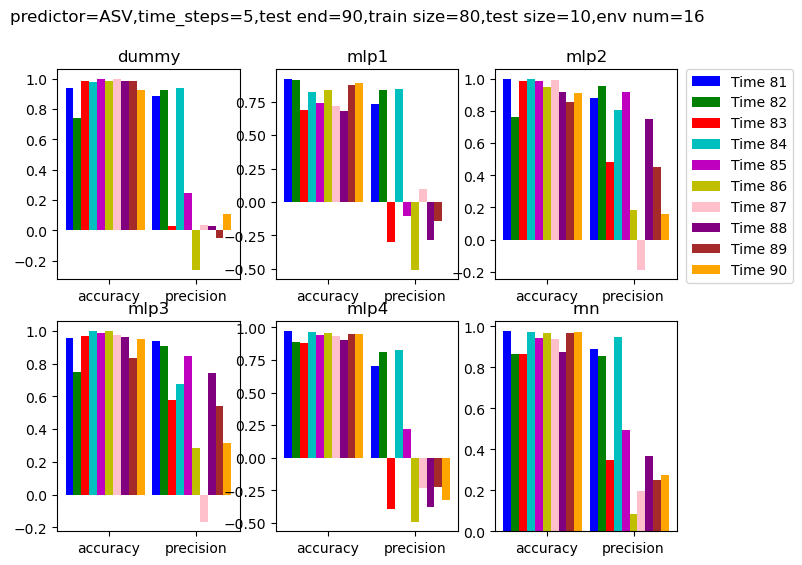

In [17]:
test_end,train_size,test_size,env_num=90,80,10,envnp.shape[1]
#X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
time_steps,for_periods,asvID=5,2,[0,1,2,3,4]

## For previous timepoint of microbial abundance as X
X_train, y_train , X_test, y_test=ts_train_test_normalize(asvnp,test_end,train_size,test_size,time_steps,for_periods,asvID)

## For environmental variables as X
X_train2,X_test2,y_train2,y_test2=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps-for_periods+1,test_size=test_size,add=0.0,clr="False",env_num=env_num)


with_both="F"
if with_both=="T":
    X_train=np.concatenate((X_train,X_train2),axis=1)
    X_test=np.concatenate((X_test,X_test2),axis=1)
    predictor="ENV+ASV"
else:
    predictor="ASV"

env_only="F"
if env_only=="T":
    X_train,X_test=X_train2,X_test2
    predictor="ENV"


dummy=make_pipeline(DummyRegressor(strategy="mean"))
lr=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),LinearRegression())
ridge=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),Ridge())
pls=make_pipeline(StandardScaler(),PLSRegression(5))
pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
rf=make_pipeline(StandardScaler(),RandomForestRegressor(random_state=0))
#my=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),MyLinearRegression())
mlp1=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=0, num_neuron=8), epochs=500, batch_size=20, verbose=0)
mlp2=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=8), epochs=500, batch_size=20, verbose=0)
mlp3=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=2, num_neuron=8), epochs=500, batch_size=20, verbose=0)
mlp4=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=4, num_neuron=8), epochs=500, batch_size=20, verbose=0)
mlp5=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=8, num_neuron=8), epochs=500, batch_size=20, verbose=0)
mlp6=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=16, num_neuron=8), epochs=500, batch_size=20, verbose=0)
rnn=KerasRegressor(model=myRNN(dim_input=X_train.shape[1],dim_output=y_train.shape[1],lstm=1), epochs=200, batch_size=20, verbose=0)

models = [dummy,mlp1,mlp2,mlp3,mlp4,rnn]
model_name=['dummy','mlp1','mlp2','mlp3','mlp4',"rnn"]
colors=['b','g','r','c','m','y','pink','purple','brown','orange']

# Compare the models
results = compare_models_timepoint(models, X_train, y_train, X_test, y_test)
timepoint=np.arange(y_test.shape[0])
# Print the results
n=0

fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for model, r2 in results.items():
    for time in timepoint:
        ax[n//3,n%3].bar(np.arange(2) + 1/(test_size+1)*time, r2[time][1:3], color = colors[time],label='Time '+str(time+train_size+1),width = 1/(test_size+1))
        ax[n//3,n%3].set_title(model_name[n])
        ax[n//3,n%3].set_xticks(np.arange(2) + 1/(test_size+1)*test_size/2,['accuracy','precision'])
    n+=1
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.suptitle("predictor="+str(predictor)+",time_steps="+str(time_steps)+","+"test end="+str(test_end)+",train size="+str(train_size)+",test size="+str(test_size)+",env num="+str(env_num))
plt.savefig('image'+str(n)+'.png',bbox_inches='tight')


## Compare models with different neurons

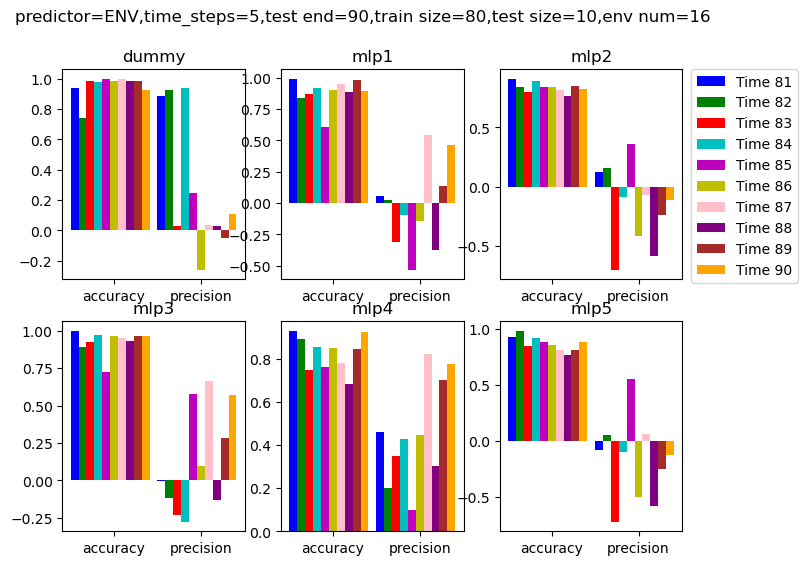

In [46]:
test_end,train_size,test_size,env_num=90,80,10,envnp.shape[1]
#X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
time_steps,for_periods,asvID=5,2,[0,1,2,3,4]

## For previous timepoint of microbial abundance as X
X_train, y_train , X_test, y_test=ts_train_test_normalize(asvnp,test_end,train_size,test_size,time_steps,for_periods,asvID)

## For environmental variables as X
X_train2,X_test2,y_train2,y_test2=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps-for_periods+1,test_size=test_size,add=0.0,clr="False",env_num=env_num)


with_both="F"
if with_both=="T":
    X_train=np.concatenate((X_train,X_train2),axis=1)
    X_test=np.concatenate((X_test,X_test2),axis=1)
    predictor="ENV+ASV"
else:
    predictor="ASV"

env_only="T"
if env_only=="T":
    X_train,X_test=X_train2,X_test2
    predictor="ENV"


dummy=make_pipeline(DummyRegressor(strategy="mean"))
lr=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),LinearRegression())
ridge=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),Ridge())
pls=make_pipeline(StandardScaler(),PLSRegression(5))
pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
rf=make_pipeline(StandardScaler(),RandomForestRegressor(random_state=0))
#my=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),MyLinearRegression())
mlp1=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=2), epochs=500, batch_size=20, verbose=0)
mlp2=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=4), epochs=500, batch_size=20, verbose=0)
mlp3=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=8), epochs=500, batch_size=20, verbose=0)
mlp4=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=16), epochs=500, batch_size=20, verbose=0)
mlp5=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=32), epochs=500, batch_size=20, verbose=0)
mlp6=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=16, num_neuron=8), epochs=500, batch_size=20, verbose=0)

models = [dummy,mlp1,mlp2,mlp3,mlp4,mlp5]
model_name=['dummy','mlp1','mlp2','mlp3','mlp4',"mlp5"]
colors=['b','g','r','c','m','y','pink','purple','brown','orange']

# Compare the models
results = compare_models_timepoint(models, X_train, y_train, X_test, y_test)
timepoint=np.arange(y_test.shape[0])
# Print the results
n=0

fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for model, r2 in results.items():
    for time in timepoint:
        ax[n//3,n%3].bar(np.arange(2) + 1/(test_size+1)*time, r2[time][1:3], color = colors[time],label='Time '+str(time+train_size+1),width = 1/(test_size+1))
        ax[n//3,n%3].set_title(model_name[n])
        ax[n//3,n%3].set_xticks(np.arange(2) + 1/(test_size+1)*test_size/2,['accuracy','precision'])
    n+=1
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.suptitle("predictor="+str(predictor)+",time_steps="+str(time_steps)+","+"test end="+str(test_end)+",train size="+str(train_size)+",test size="+str(test_size)+",env num="+str(env_num))
plt.savefig('image'+str(n)+'.png',bbox_inches='tight')


## Compare model of different epochs

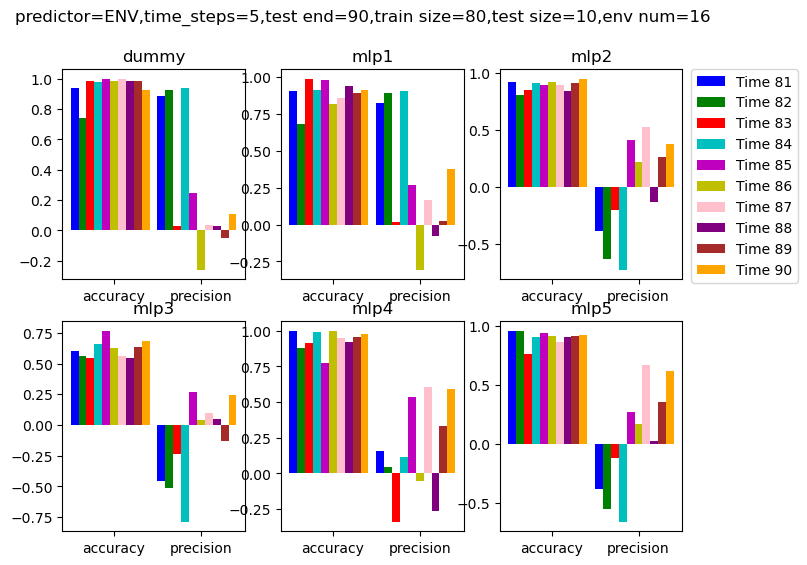

In [48]:
test_end,train_size,test_size,env_num=90,80,10,envnp.shape[1]
#X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
time_steps,for_periods,asvID=5,2,[0,1,2,3,4]

## For previous timepoint of microbial abundance as X
X_train, y_train , X_test, y_test=ts_train_test_normalize(asvnp,test_end,train_size,test_size,time_steps,for_periods,asvID)

## For environmental variables as X
X_train2,X_test2,y_train2,y_test2=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps-for_periods+1,test_size=test_size,add=0.0,clr="False",env_num=env_num)


with_both="F"
if with_both=="T":
    X_train=np.concatenate((X_train,X_train2),axis=1)
    X_test=np.concatenate((X_test,X_test2),axis=1)
    predictor="ENV+ASV"
else:
    predictor="ASV"

env_only="T"
if env_only=="T":
    X_train,X_test=X_train2,X_test2
    predictor="ENV"


dummy=make_pipeline(DummyRegressor(strategy="mean"))
lr=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),LinearRegression())
ridge=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),Ridge())
pls=make_pipeline(StandardScaler(),PLSRegression(5))
pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
rf=make_pipeline(StandardScaler(),RandomForestRegressor(random_state=0))
#my=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),MyLinearRegression())
mlp1=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=16), epochs=50,batch_size=20, verbose=0)
mlp2=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=16), epochs=100, batch_size=20, verbose=0)
mlp3=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=16), epochs=200, batch_size=20, verbose=0)
mlp4=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=16), epochs=500, batch_size=20, verbose=0)
mlp5=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=16), epochs=1000, batch_size=20, verbose=0)
mlp6=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=16, num_neuron=8), epochs=500, batch_size=20, verbose=0)

models = [dummy,mlp1,mlp2,mlp3,mlp4,mlp5]
model_name=['dummy','mlp1','mlp2','mlp3','mlp4',"mlp5"]
colors=['b','g','r','c','m','y','pink','purple','brown','orange']

# Compare the models
results = compare_models_timepoint(models, X_train, y_train, X_test, y_test)
timepoint=np.arange(y_test.shape[0])
# Print the results
n=0

fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for model, r2 in results.items():
    for time in timepoint:
        ax[n//3,n%3].bar(np.arange(2) + 1/(test_size+1)*time, r2[time][1:3], color = colors[time],label='Time '+str(time+train_size+1),width = 1/(test_size+1))
        ax[n//3,n%3].set_title(model_name[n])
        ax[n//3,n%3].set_xticks(np.arange(2) + 1/(test_size+1)*test_size/2,['accuracy','precision'])
    n+=1
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.suptitle("predictor="+str(predictor)+",time_steps="+str(time_steps)+","+"test end="+str(test_end)+",train size="+str(train_size)+",test size="+str(test_size)+",env num="+str(env_num))
plt.savefig('image'+str(n)+'.png',bbox_inches='tight')


(74, 5)


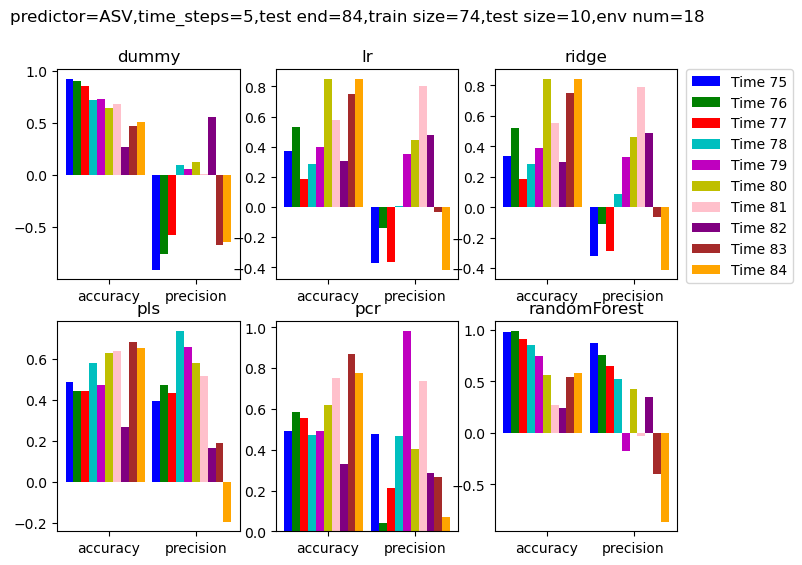

In [217]:
test_end,train_size,test_size,env_num=84,74,10,envnp.shape[1]
#X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
time_steps,for_periods,asvID=5,1,[0,1,2,3,4]

## For previous timepoint of microbial abundance as X
X_train, y_train , X_test, y_test=ts_train_test_normalize(asvnp,test_end,train_size,test_size,time_steps,for_periods,asvID)

## For environmental variables as X
X_train2,X_test2,y_train2,y_test2=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps,test_size=test_size,add=0.0,clr="False",env_num=env_num)


with_both="F"
if with_both=="T":
    X_train=np.concatenate((X_train,X_train2),axis=1)
    X_test=np.concatenate((X_test,X_test2),axis=1)
    predictor="ENV+ASV"
else:
    predictor="ASV"

env_only="F"
if env_only=="T":
    X_train,X_test=X_train2,X_test2
    predictor="ENV"


dummy=make_pipeline(DummyRegressor(strategy="mean"))
lr=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),LinearRegression())
ridge=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),Ridge())
pls=make_pipeline(StandardScaler(),PLSRegression(5))
pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
rf=make_pipeline(StandardScaler(),RandomForestRegressor(random_state=0))
#my=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),MyLinearRegression())


models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]
colors=['b','g','r','c','m','y','pink','purple','brown','orange']

# Compare the models
results = compare_models_timepoint(models, X_train, y_train, X_test, y_test)
timepoint=np.arange(y_test.shape[0])
# Print the results
n=0

fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for model, r2 in results.items():
    for time in timepoint:
        ax[n//3,n%3].bar(np.arange(2) + 1/(test_size+1)*time, r2[time][1:3], color = colors[time],label='Time '+str(time+train_size+1),width = 1/(test_size+1))
        ax[n//3,n%3].set_title(model_name[n])
        ax[n//3,n%3].set_xticks(np.arange(2) + 1/(test_size+1)*test_size/2,['accuracy','precision'])
    n+=1
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.suptitle("predictor="+str(predictor)+",time_steps="+str(time_steps)+","+"test end="+str(test_end)+",train size="+str(train_size)+",test size="+str(test_size)+",env num="+str(env_num))
plt.savefig('image'+str(n)+'.png',bbox_inches='tight')


(74, 5)


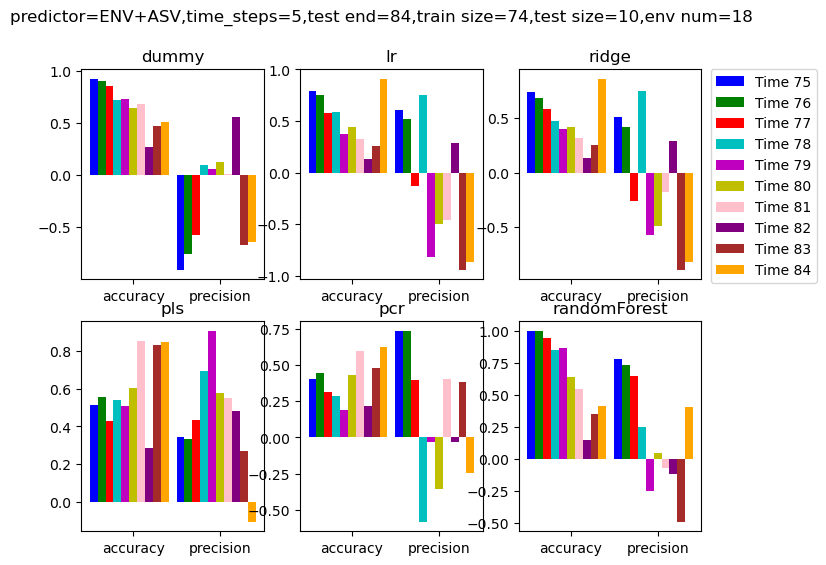

In [218]:
test_end,train_size,test_size,env_num=84,74,10,envnp.shape[1]
#X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
time_steps,for_periods,asvID=5,1,[0,1,2,3,4]

## For previous timepoint of microbial abundance as X
X_train, y_train , X_test, y_test=ts_train_test_normalize(asvnp,test_end,train_size,test_size,time_steps,for_periods,asvID)

## For environmental variables as X
X_train2,X_test2,y_train2,y_test2=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps,test_size=test_size,add=0.0,clr="False",env_num=env_num)


with_both="T"
if with_both=="T":
    X_train=np.concatenate((X_train,X_train2),axis=1)
    X_test=np.concatenate((X_test,X_test2),axis=1)
    predictor="ENV+ASV"
else:
    predictor="ASV"

env_only="F"
if env_only=="T":
    X_train,X_test=X_train2,X_test2
    predictor="ENV"


dummy=make_pipeline(DummyRegressor(strategy="mean"))
lr=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),LinearRegression())
ridge=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),Ridge())
pls=make_pipeline(StandardScaler(),PLSRegression(5))
pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
rf=make_pipeline(StandardScaler(),RandomForestRegressor(random_state=0))
#my=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),MyLinearRegression())


models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]
colors=['b','g','r','c','m','y','pink','purple','brown','orange']

# Compare the models
results = compare_models_timepoint(models, X_train, y_train, X_test, y_test)
timepoint=np.arange(y_test.shape[0])
# Print the results
n=0

fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for model, r2 in results.items():
    for time in timepoint:
        ax[n//3,n%3].bar(np.arange(2) + 1/(test_size+1)*time, r2[time][1:3], color = colors[time],label='Time '+str(time+train_size+1),width = 1/(test_size+1))
        ax[n//3,n%3].set_title(model_name[n])
        ax[n//3,n%3].set_xticks(np.arange(2) + 1/(test_size+1)*test_size/2,['accuracy','precision'])
    n+=1
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.suptitle("predictor="+str(predictor)+",time_steps="+str(time_steps)+","+"test end="+str(test_end)+",train size="+str(train_size)+",test size="+str(test_size)+",env num="+str(env_num))
plt.savefig('image'+str(n)+'.png',bbox_inches='tight')


## Use previous points of env and asv togther

(80, 5)
(80, 16)


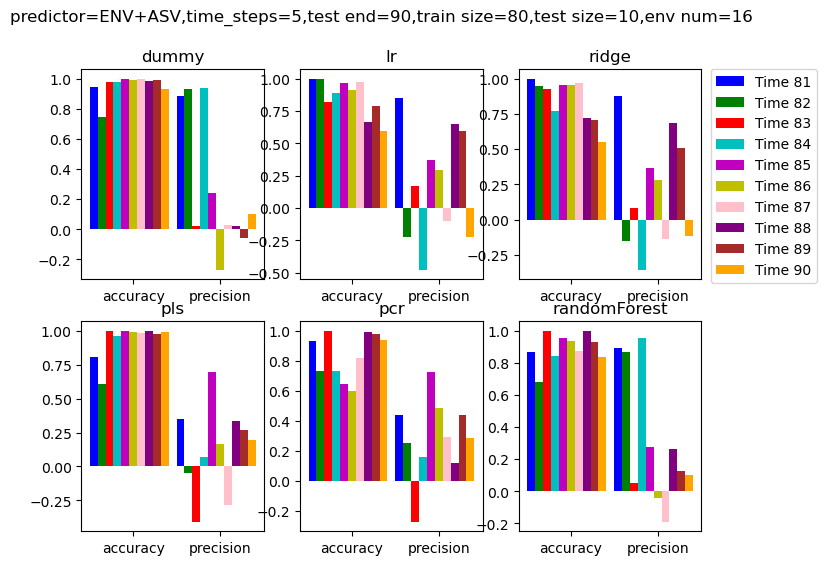

In [223]:
test_end,train_size,test_size,env_num=90,80,10,envnp.shape[1]
#X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
time_steps,for_periods,asvID=5,1,[0,1,2,3,4]

## For previous timepoint of microbial abundance as X
X_train, y_train , X_test, y_test=ts_train_test_normalize(asvnp,test_end,train_size,test_size,time_steps,for_periods,asvID)

## For environmental variables as X, if use previous environmental variables as predictor
X_train2,y_train2,X_test2,y_test2=ts_train_test_normalize(envnp,test_end,train_size,test_size,time_steps,for_periods,range(0,envnp.shape[1]))



with_both="T"
if with_both=="T":
    X_train=np.concatenate((X_train,X_train2),axis=1)
    X_test=np.concatenate((X_test,X_test2),axis=1)
    predictor="ENV+ASV"
else:
    predictor="ASV"

env_only="F"
if env_only=="T":
    X_train,X_test=X_train2,X_test2
    predictor="ENV"


dummy=make_pipeline(DummyRegressor(strategy="mean"))
lr=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),LinearRegression())
ridge=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),Ridge())
pls=make_pipeline(StandardScaler(),PLSRegression(5))
pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
rf=make_pipeline(StandardScaler(),RandomForestRegressor(random_state=0))
#my=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),MyLinearRegression())


models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]
colors=['b','g','r','c','m','y','pink','purple','brown','orange']

# Compare the models
results = compare_models_timepoint(models, X_train, y_train, X_test, y_test)
timepoint=np.arange(y_test.shape[0])
# Print the results
n=0

fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for model, r2 in results.items():
    for time in timepoint:
        ax[n//3,n%3].bar(np.arange(2) + 1/(test_size+1)*time, r2[time][1:3], color = colors[time],label='Time '+str(time+train_size+1),width = 1/(test_size+1))
        ax[n//3,n%3].set_title(model_name[n])
        ax[n//3,n%3].set_xticks(np.arange(2) + 1/(test_size+1)*test_size/2,['accuracy','precision'])
    n+=1
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.suptitle("predictor="+str(predictor)+",time_steps="+str(time_steps)+","+"test end="+str(test_end)+",train size="+str(train_size)+",test size="+str(test_size)+",env num="+str(env_num))
plt.savefig('image'+str(n)+'.png',bbox_inches='tight')


## Use previous and current points of env and asv togther

(80, 5)
(80, 16)


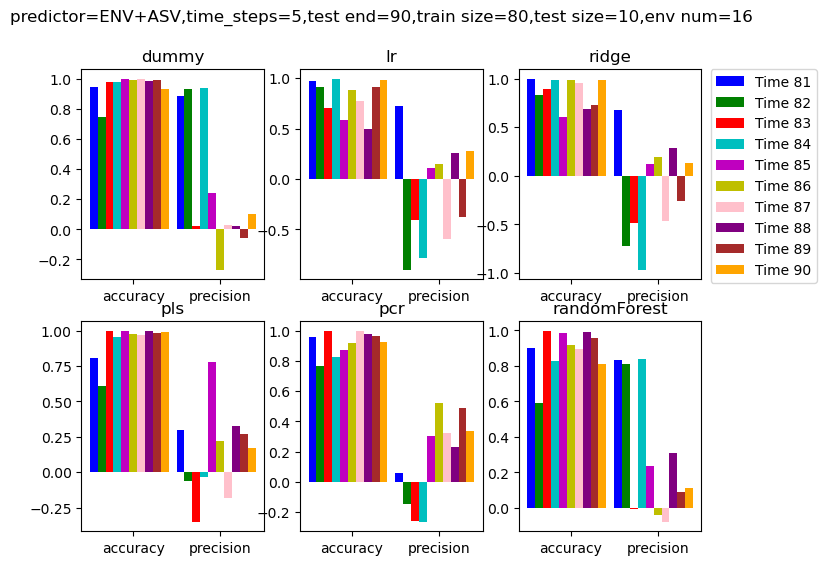

In [245]:
test_end,train_size,test_size,env_num=90,80,10,envnp.shape[1]
#X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
time_steps,for_periods,asvID=5,1,[0,1,2,3,4]

## For previous timepoint of microbial abundance as X
X_train, y_train , X_test, y_test=ts_train_test_normalize(asvnp,test_end,train_size,test_size,time_steps,for_periods,asvID)

## For environmental variables as X, if use previous environmental variables as predictor
X_train2,y_train2,X_test2,y_test2=ts_train_test_normalize(envnp,test_end,train_size,test_size,time_steps,for_periods,range(0,envnp.shape[1]))

X_train3,X_test3,y_train3,y_test3=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size-time_steps,test_size=test_size,add=0.0,clr="False",env_num=env_num)

X_train2=np.concatenate((X_train2,X_train3),axis=1)
X_test2=np.concatenate((X_test2,X_test3),axis=1)

with_both="T"
if with_both=="T":
    X_train=np.concatenate((X_train,X_train2),axis=1)
    X_test=np.concatenate((X_test,X_test2),axis=1)
    predictor="ENV+ASV"
else:
    predictor="ASV"

env_only="F"
if env_only=="T":
    X_train,X_test=X_train2,X_test2
    predictor="ENV"


dummy=make_pipeline(DummyRegressor(strategy="mean"))
lr=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),LinearRegression())
ridge=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),Ridge())
pls=make_pipeline(StandardScaler(),PLSRegression(5))
pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
rf=make_pipeline(StandardScaler(),RandomForestRegressor(random_state=0))
#my=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),MyLinearRegression())


models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]
colors=['b','g','r','c','m','y','pink','purple','brown','orange']

# Compare the models
results = compare_models_timepoint(models, X_train, y_train, X_test, y_test)
timepoint=np.arange(y_test.shape[0])
# Print the results
n=0

fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for model, r2 in results.items():
    for time in timepoint:
        ax[n//3,n%3].bar(np.arange(2) + 1/(test_size+1)*time, r2[time][1:3], color = colors[time],label='Time '+str(time+train_size+1),width = 1/(test_size+1))
        ax[n//3,n%3].set_title(model_name[n])
        ax[n//3,n%3].set_xticks(np.arange(2) + 1/(test_size+1)*test_size/2,['accuracy','precision'])
    n+=1
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.suptitle("predictor="+str(predictor)+",time_steps="+str(time_steps)+","+"test end="+str(test_end)+",train size="+str(train_size)+",test size="+str(test_size)+",env num="+str(env_num))
plt.savefig('image'+str(n)+'.png',bbox_inches='tight')


In [11]:
test_end,train_size,test_size,env_num=envnp.shape[0],envnp.shape[0]-6,6,envnp.shape[1]
X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)

dummy=make_pipeline(DummyRegressor(strategy="mean"))
lr=make_pipeline(StandardScaler(),LinearRegression())
ridge=make_pipeline(StandardScaler(),Ridge())
pls=make_pipeline(StandardScaler(),PLSRegression(5))
pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
rf=make_pipeline(StandardScaler(),RandomForestRegressor(random_state=0))
my=make_pipeline(StandardScaler(),SelectFromModel(LinearRegression()),MyLinearRegression())


models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]
colors=['b','g','r','c','m','y']

# Compare the models
results = compare_models_timepoint(models, X_train, y_train, X_test, y_test)
timepoint=np.arange(y_test.shape[0])
# Print the results
n=0

fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for model, r2 in results.items():
    for time in timepoint:
        ax[n//3,n%3].bar(np.arange(3) + 0.1*time, r2[time][1:], color = colors[time],label='week '+str(time),width = 0.1)
        ax[n//3,n%3].set_title(model_name[n])
        ax[n//3,n%3].set_xticks(np.arange(3) + 0.1*2.5,['accuracy','precision','ccc'])
    n+=1
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.suptitle("test end="+str(test_end)+",train size="+str(train_size)+",test size="+str(test_size)+",env num="+str(env_num))
plt.savefig('image'+str(n)+'.png',bbox_inches='tight')


NameError: name 'MyLinearRegression' is not defined

## Compare multiple models for multiple datasets

In [22]:
import glob
directory = 'C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\'


files_for=glob.glob(glob.escape(directory)+"*\\*ASV.Top100.csv")

files_for=[files_for[i].split(".")[0] for i in range(len(files_for))]
site=[files_for[i].split("\\")[-1] for i in range(len(files_for))]


In [23]:
files_for

['C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\Air01\\Air01A1',
 'C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\Human01\\Human01A1',
 'C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\Human01\\Human01A2',
 'C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\Human02\\Human02A1',
 'C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\Human02\\Human02B1',
 'C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\Lake01\\Lake01A1',
 'C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\Lake01\\Lake01A2',
 'C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\Lake01\\Lake01A3',
 '

In [99]:
for i in range(len(site)):
    env=pd.read_csv(files_for[i]+'.Env.fillna.csv')
    asv=pd.read_csv(files_for[i]+'.ASV.Top1000.csv') ## or read top 100 asv files
    envnp=env[env.columns[1:]].to_numpy(dtype='float32')
    asvnp=asv[asv.columns[1:]].to_numpy(dtype='float32').T
    a=envnp.max(0)
    a[a==0]=1
    envnp=envnp/a.reshape(-1,envnp.shape[1])
    asvnp=asvnp/asvnp.sum(1).reshape(asvnp.shape[0],-1)
    outpath='C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\MLP_top1000\\'
    test_end,test_size,env_num=envnp.shape[0],12,envnp.shape[1]
    time_steps,for_periods,asvID=5,1,range(asvnp.shape[1])
    dummy=make_pipeline(DummyRegressor(strategy="mean"))
    train_size_c=[envnp.shape[0]-12]
    result_train_size={}
    predictor_type=['previous.asv','current.env']
    for train_size in train_size_c:
        for predictor in predictor_type:
            X_train, y_train , X_test, y_test=data_load(site[i],models, model_name,envnp,asvnp,predictor,time_steps,for_periods,asvID,test_end,train_size,test_size,
                                             add=0.0,clr="False",env_num=env_num,filepath=outpath)
            mlp1=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=1, num_neuron=8), epochs=200,batch_size=20, verbose=0)
            mlp2=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=2, num_neuron=16), epochs=200, batch_size=20, verbose=0)
            mlp3=KerasRegressor(model=MLP(dim_input=X_train.shape[1],dim_output=y_train.shape[1],num_layer=3, num_neuron=32), epochs=200, batch_size=20, verbose=0)
    
            models = [dummy,mlp1,mlp2,mlp3]
            model_name=['dummy','mlp1','mlp2','mlp3']
            
            compare_models_output_timeseries(site[i],models, model_name,envnp,asvnp,predictor,time_steps,for_periods,asvID,test_end,train_size,test_size,
                                             add=0.0,clr="False",env_num=env_num,filepath=outpath)


    

Air01A1
Air01A1
Air01A1
Air01A1
Human01A1
Human01A1
Human01A1
Human01A1
Human01A2
Human01A2
Human01A2
Human01A2
Human02A1
Human02A1
Human02A1
Human02A1
Human02B1
Human02B1
Human02B1
Human02B1
Lake01A1
Lake01A1
Lake01A1
Lake01A1
Lake01A2
Lake01A2
Lake01A2
Lake01A2
Lake01A3
Lake01A3
Lake01A3
Lake01A3
Ocean01A1
Ocean01A1
Ocean01A1
Ocean01A1
Ocean01B1
Ocean01B1
Ocean01B1
Ocean01B1
Ocean01C1
Ocean01C1
Ocean01C1
Ocean01C1
Soil01A1
Soil01A1
Soil01A1
Soil01A1
Soil01B1
Soil01B1
Soil01B1
Soil01B1
Wastewater01A2
Wastewater01A2
Wastewater01A2
Wastewater01A2
Wastewater01A3
Wastewater01A3
Wastewater01A3
Wastewater01A3
Wastewater01B1
Wastewater01B1
Wastewater01B1
Wastewater01B1
Wastewater01C1
Wastewater01C1
Wastewater01C1
Wastewater01C1
Wastewater02A1
Wastewater02A1
Wastewater02A1
Wastewater02A1
Wastewater02B1
Wastewater02B1
Wastewater02B1
Wastewater02B1


## Simple RNN and LSTM

In [24]:
for i in range(len(site)):
    env=pd.read_csv(files_for[i]+'.Env.fillna.csv')
    asv=pd.read_csv(files_for[i]+'.ASV.Top100.csv') ## or read top 100 asv files
    envnp=env[env.columns[1:]].to_numpy(dtype='float32')
    asvnp=asv[asv.columns[1:]].to_numpy(dtype='float32').T
    a=np.abs(envnp).max(0)
    a[a==0]=1
    envnp=envnp/a.reshape(-1,envnp.shape[1])
    asvnp=asvnp/asvnp.sum(1).reshape(asvnp.shape[0],-1)
    outpath='C:\\Users\\10051\\Documents\\PhD\\project\\DARPA_predict dynamics\\data analysis\\test for other data\\RNN_top100\\'
    test_end,test_size,env_num=envnp.shape[0],12,envnp.shape[1]
    time_steps,for_periods,asvID=5,1,range(asvnp.shape[1])
    dummy=make_pipeline(DummyRegressor(strategy="mean"))
    train_size_c=[envnp.shape[0]-12]
    result_train_size={}
    predictor_type=['previous.asv']
    for train_size in train_size_c:
        for predictor in predictor_type:
            X_train, y_train , X_test, y_test=data_load(site[i],models, model_name,envnp,asvnp,predictor,time_steps,for_periods,asvID,test_end,train_size,test_size,
                                             add=0.0,clr="False",env_num=env_num,filepath=outpath)
            rnn=KerasRegressor(model=myRNN(dim_input=X_train.shape[1],dim_output=y_train.shape[1],lstm=0), epochs=200, batch_size=20, verbose=0)
            lstm=KerasRegressor(model=myRNN(dim_input=X_train.shape[1],dim_output=y_train.shape[1],lstm=1), epochs=200, batch_size=20, verbose=0)
            
            models = [dummy,rnn,lstm]
            model_name=['dummy','rnn','lstm']
            
            compare_models_output_timeseries(site[i],models, model_name,envnp,asvnp,predictor,time_steps,for_periods,asvID,test_end,train_size,test_size,
                                             add=0.0,clr="False",env_num=env_num,filepath=outpath)


    

Air01A1
Air01A1
Human01A1
Human01A1
Human01A2
Human01A2
Human02A1
Human02A1
Human02B1
Human02B1
Lake01A1
Lake01A1
Lake01A2
Lake01A2
Lake01A3
Lake01A3
Ocean01A1
Ocean01A1
Ocean01B1
Ocean01B1
Ocean01C1
Ocean01C1
Soil01A1
Soil01A1
Soil01B1
Soil01B1
Wastewater01A2
Wastewater01A2
Wastewater01A3
Wastewater01A3
Wastewater01B1
Wastewater01B1
Wastewater01C1
Wastewater01C1
Wastewater02A1
Wastewater02A1
Wastewater02B1
Wastewater02B1


In [126]:
predictor

'previous.env'

In [135]:
y_train.shape

(67, 5)

## Effect of train size 


In [9]:
test_end,test_size,env_num=52,6,20

pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]

train_size_c=[i for i in range(5,46,5)]
result_train_size={}

for train_size in train_size_c:
    X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
    r2 = list(compare_models_timepoint(models, X_train, y_train, X_test, y_test).values())[0]
    compare_models_output(models, model_name,envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num,filepath=outpath)
    result_train_size[train_size]=r2


C:\Users\10051\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 4
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Users\10051\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 4
  warnings.warn(f"Y residual is constant at iteration {k}")


In [19]:
i

13

Text(0.5, 0, 'data size of train set')

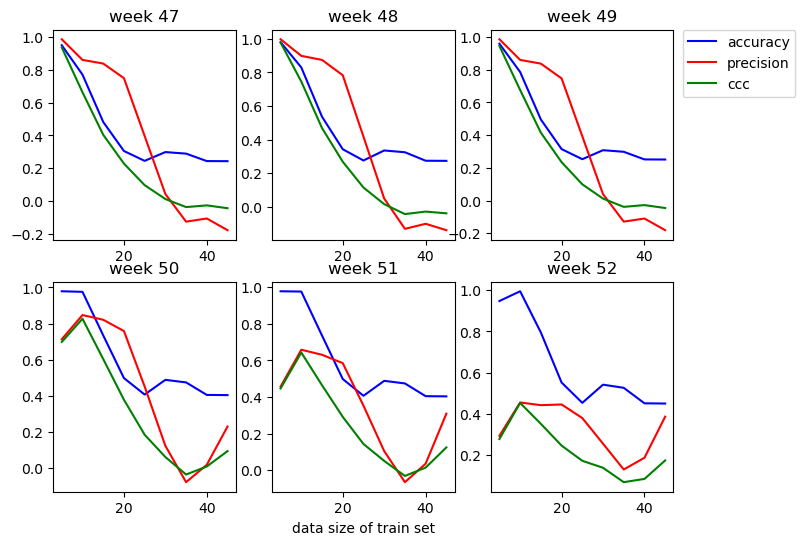

In [10]:
fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for time in range(0,6):
    accuracy=[result_train_size[train_size][time][1] for train_size in train_size_c]
    precision=[result_train_size[train_size][time][2] for train_size in train_size_c]
    ccc=[result_train_size[train_size][time][3] for train_size in train_size_c]
    ax[position[time][0],position[time][1]].plot(train_size_c,accuracy,color="b",label="accuracy")
    ax[position[time][0],position[time][1]].plot(train_size_c,precision,color="r",label="precision")
    ax[position[time][0],position[time][1]].plot(train_size_c,ccc,color="g",label="ccc")
    ax[position[time][0],position[time][1]].set_title('week '+str(time+47))
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('data size of train set')

## Effect of the range of test data

In [11]:
train_size,test_size,env_num=30,6,27

pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]

test_end_c=[i for i in range(36,53)]
result_test_end={}

for test_end in test_end_c:
    X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
    r2 = list(compare_models_timepoint(models, X_train, y_train, X_test, y_test).values())[0]
    compare_models_output(models, model_name,envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num,filepath=outpath)
    result_test_end[test_end]=r2


Text(0.5, 0, 'End of test data size')

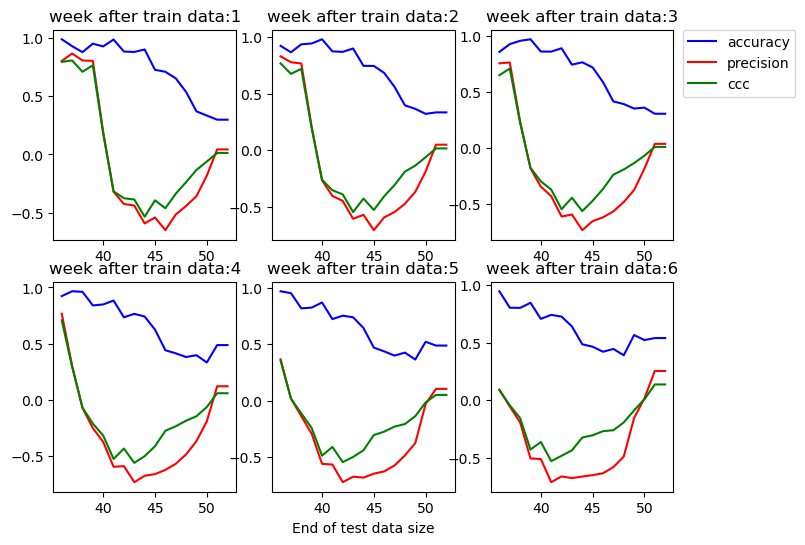

In [12]:
fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for time in range(0,6):
    accuracy=[result_test_end[test_end][time][1] for test_end in test_end_c]
    precision=[result_test_end[test_end][time][2] for test_end in test_end_c]
    ccc=[result_test_end[test_end][time][3] for test_end in test_end_c]
    ax[position[time][0],position[time][1]].plot(test_end_c,accuracy,color="b",label="accuracy")
    ax[position[time][0],position[time][1]].plot(test_end_c,precision,color="r",label="precision")
    ax[position[time][0],position[time][1]].plot(test_end_c,ccc,color="g",label="ccc")
    ax[position[time][0],position[time][1]].set_title('week after train data:'+str(time+1))
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('End of test data size')

## Effect of number of env variables

In [13]:
env1 = ["MLSS","Flowrate","Temp.AS","Days","SRT","DO","FM","Temp.Avg.WeekMean","COD.rmr",         "BOD.rmr","TN.rm","Precipitation.SamplingDate","Precipitation.MonthAccum","SVI",
         "TN.rmr","COD.rm","Precipitation.WeekMean","Temp.Avg.SamplingDate",
         "pH","NH4.rmr","BOD.rm","TP.rmr","Season","Precipitation.WeekAccum",
         "TP.rm","MLVSS","NH4.rm"]
env2 = ["FM","MLVSS","BOD.rmr","Season","DO","NH4.rmr",
         "Precipitation.WeekAccum","Flowrate","TN.rm",
         "TN.rmr","TP.rm","SRT","TP.rmr","COD.rm","BOD.rm",
         "Temp.Avg.WeekMean","Precipitation.WeekMean","MLSS",
         "COD.rmr","SVI","Precipitation.MonthAccum",
         "Temp.Avg.SamplingDate","Precipitation.SamplingDate","pH",
         "Days","Temp.AS","NH4.rm"]
env3 = ["MLSS","Temp.Avg.SamplingDate","FM",
         "NH4.rm","Days","MLVSS",
         "Precipitation.WeekAccum","TP.rm","Temp.Avg.WeekMean",
         "TN.rmr","SRT","SVI",
         "TN.rm","NH4.rmr","Precipitation.SamplingDate",
         "COD.rm","DO","COD.rmr","BOD.rmr","pH","Temp.AS",
         "Precipitation.MonthAccum","BOD.rm","TP.rmr",
         "Season","Precipitation.WeekMean","Flowrate"]

In [14]:
env=env[env1]
envnp1=env[env.columns[1:]].to_numpy(dtype='float32')

env=env[env2]
envnp2=env[env.columns[1:]].to_numpy(dtype='float32')

env=env[env3]
envnp3=env[env.columns[1:]].to_numpy(dtype='float32')

In [15]:
test_end,train_size,test_size=52,45,6
envnp=envnp3

pcr = make_pipeline(StandardScaler(), PCA(n_components=5),LinearRegression())
models = [dummy,lr,ridge,pls,pcr,rf]
model_name=['dummy','lr','ridge','pls','pcr',"randomForest"]

env_num_c=[i for i in range(5,28)]
result_env_num={}

for env_num in env_num_c:
    X_train,X_test,y_train,y_test=split_samples2(envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num)
    r2 = list(compare_models_timepoint(models, X_train, y_train, X_test, y_test).values())[0]
    compare_models_output(models, model_name,envnp,asvnp,test_end=test_end,train_size=train_size,test_size=test_size,add=0.0,clr="False",env_num=env_num,filepath=outpath)
    result_env_num[env_num]=r2


Text(0.5, 0, 'Number of environmental factors')

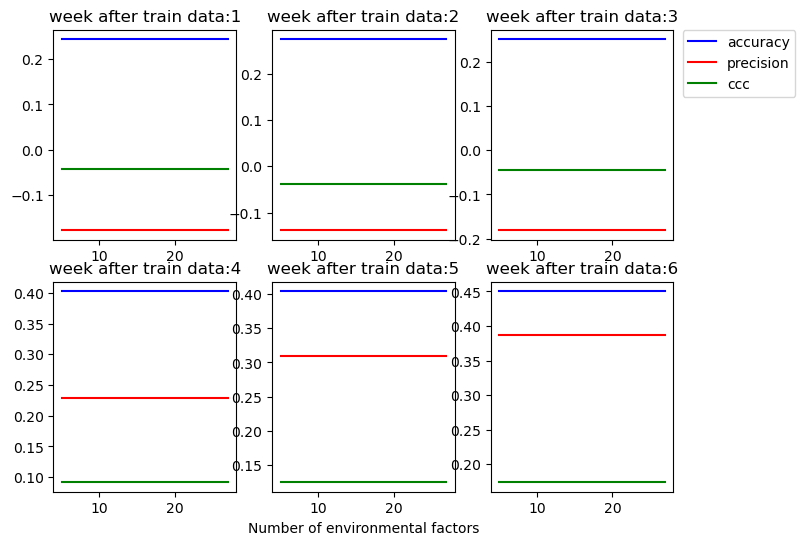

In [16]:
fig,ax=plt.subplots(2,3,figsize=[8,6])
position=[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for time in range(0,6):
    accuracy=[result_env_num[env_num][time][1] for env_num in env_num_c]
    precision=[result_env_num[env_num][time][2] for env_num in env_num_c]
    ccc=[result_env_num[env_num][time][3] for env_num in env_num_c]
    ax[position[time][0],position[time][1]].plot(env_num_c,accuracy,color="b",label="accuracy")
    ax[position[time][0],position[time][1]].plot(env_num_c,precision,color="r",label="precision")
    ax[position[time][0],position[time][1]].plot(env_num_c,ccc,color="g",label="ccc")
    ax[position[time][0],position[time][1]].set_title('week after train data:'+str(time+1))
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of environmental factors')